# comma package tutorial

In [1]:
from comma.model import Model
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import date
from functools import reduce

pd.set_option('display.max_columns', None)

### Step 1. Initialise the model


We initialise a model with: 

- A population size of 500 individuals. 

- Population parameters estimated via IPF(`use_ipf = True`). Note that if the joint probabilities are not necessary, then `use_ipf = False` will load parameters specified in `params_individual.json`. This will initiate a sampling from the distribution outlined in the json file, which does *not* take into account the joint probabilities within variables.

- Seed = 0. This will ensure reproducibility in the output.

- dir_params = '../parameters'. This is the folder containing all our configuration files: matrices of action probabilities, parameters of population composition and matrices of the effects of actions on mental health

In [2]:
size = 5914
dir_params = '../parameters/'
use_ipf = True
seed = 0

model = Model(size, dir_params, use_ipf, seed)

Populating individuals: 100%|█████████████████████████████████████████████████████| 5914/5914 [00:00<00:00, 27497.38i/s]


To see who are the agents, you can print their features:

In [3]:
print(f'there are {len(model.agents)} individuals')

there are 5914 individuals


In [13]:
print(f'these are the feature of one individual: \n\n{model.agents[9].get_features()}')

these are the feature of one individual: 

baseline                                  1
age_group__1                              0
age_group__2                              0
age_group__3                              0
age_group__4                              1
gender_f                                  1
gender_m                                  0
education_high                            0
education_low                             0
education_medium                          1
education_unknown                         0
unemployed_no                             1
unemployed_yes                            0
have_partner_no                           0
have_partner_yes                          0
have_partner_unknown                      1
depressed_no                              1
depressed_yes                             0
depressed_unknown                         0
children_presence_no                      0
children_presence_yes                     0
children_presence_unknown        

### Step 2. Run the model

We simulate the mental health trajectory of the individuals generated above for ~30/32 days (1 step = 1 day). Within these days, we hypothesise 2 types of lockdowns: easy and hard.

For instance, we are interested in the period of time from the 19th of April 2020 to the 20th of May 2020. This was an 'easy' lockdown

In [3]:
# This code is contributed by Jyothi pinjala

def numOfDays(date1, date2):
	return reduce(lambda x, y: (y-x).days, [date1, date2])

date1 = date(2020, 4, 19)
date2 = date(2020, 5, 20)
print(numOfDays(date1, date2), "days")

31 days


In [4]:
n_days = numOfDays(date1, date2)

#### Easy lockdown period

In [5]:
steps = n_days + 1 # so that we include also the last day

In [6]:
lockdown_pattern = ["easy"]*steps

In [7]:
model.run(steps=steps,
          lockdown_policy=lockdown_pattern,
          out_path="simulation_results_easy.csv",
          starting_date="2020-04-19")

Data fetched


Running simulation: 100%|███████████████████████████████████████████████████████████████| 32/32 [01:16<00:00,  2.39s/it]


In [19]:
print(f'We simulated {len(lockdown_pattern)} days')

We simulated 32 days


The model at the end of the run will output "simulation_results.csv". 

Agents' features are not part of the output file, however we can save them separately and merge them later in our analyses:

In [20]:
agents_features = []
for agent in model.agents:
    agents_features.append(agent.get_features())

In [21]:
agents_features = pd.DataFrame(agents_features)

In [22]:
agents_features.to_csv('agents_feats_easy.csv', index=False)

#### Hard lockdown period

This period goes from the 5th of january 2021, to the 8th of february 2021. 34 days.

In [8]:
size = 5914
dir_params = '../parameters/'
use_ipf = True
seed = 0

model = Model(size, dir_params, use_ipf, seed)

Populating individuals: 100%|█████████████████████████████████████████████████████| 5914/5914 [00:00<00:00, 28527.76i/s]


In [9]:
date1 = date(2021, 1, 5)
date2 = date(2021, 2, 8)
print(numOfDays(date1, date2), "days")

34 days


In [10]:
n_days = numOfDays(date1, date2)

In [11]:
steps = n_days + 1 # so that we include also the last day

In [27]:
lockdown_pattern = ["hard"]*steps

In [28]:
model.run(steps=steps,
          lockdown_policy=lockdown_pattern,
          out_path="simulation_results_hard.csv",
          starting_date="2021-01-05")

Data fetched


Running simulation: 100%|█████████████████████████| 35/35 [01:27<00:00,  2.50s/it]


Save the features for subsequent analyses:

In [29]:
agents_features = []
for agent in model.agents:
    agents_features.append(agent.get_features())

In [30]:
agents_features = pd.DataFrame(agents_features)

In [31]:
agents_features.to_csv('agents_feats_hard.csv', index=False)

### Step 3. Load and Plot the results

In [2]:
data = pd.read_csv('simulation_results_easy.csv', delimiter=";", decimal=",")

In [4]:
display(data.head())

,step_id,lockdown,agent_id,delta_mental_health,cumulative_mental_health,covid_status,days_since_first_infection
0,0,easy,0,0.0,6.070,0,NaN
1,0,easy,1,0.0,-15.500,0,NaN
2,0,easy,2,0.0,-0.630,0,NaN
3,0,easy,3,0.0,5.870,0,NaN
4,0,easy,4,0.0,-6.799,0,NaN


In [5]:
data['lockdown'].unique()

array(['easy'], dtype=object)

#### Group by step_id and compute the average mental health score

In [6]:
grouped_data = data.groupby(['step_id', 'lockdown']).mean().reset_index()
grouped_data

,step_id,lockdown,agent_id,delta_mental_health,cumulative_mental_health,covid_status,days_since_first_infection
0,0,easy,2956.5,0.000000,-4.746423,0.000676,1.00
1,1,easy,2956.5,-4.863083,-9.611502,0.000676,2.00
2,2,easy,2956.5,-4.820787,-14.434275,0.000676,3.00
3,3,easy,2956.5,-4.807597,-19.243865,0.000676,4.00
4,4,easy,2956.5,-4.786782,-24.032648,0.000676,5.00
5,5,easy,2956.5,-4.793848,-28.828488,0.000676,6.00
6,6,easy,2956.5,-4.770826,-33.601319,0.000676,7.00
7,7,easy,2956.5,-4.744015,-38.347335,0.000676,8.00
8,8,easy,2956.5,-4.747015,-43.096353,0.000676,9.00
9,9,easy,2956.5,-4.758230,-47.856590,0.000676,10.00


In [7]:
infected = data[data['covid_status'] == 1]

In [8]:
print(f"There have been {infected['agent_id'].nunique()} infected individuals")

There have been 4 infected individuals


In [9]:
print(f"There have been positive for {infected.groupby('agent_id')['days_since_first_infection'].max().sum()} days")

There have been positive for 64.0 days


In [10]:
print(f"The maximum duration of the infection was {infected['days_since_first_infection'].max()} days")

The maximum duration of the infection was 32.0 days


### Cumulative mental health across time per agent

In [14]:
agg_df = data.groupby(['step_id', 'lockdown'])['cumulative_mental_health'].mean().reset_index()
agg_df['label'] = 'average'

few_points = data[data['agent_id'] <= 3]
other_points = data[data['agent_id'] > 3]

max_step_ids = data.groupby('lockdown')['step_id'].max().reset_index()


In [15]:
# Create a dictionary with a unique color for each agent_id
colors = {}
unique_agents = data['agent_id'].unique()
for agent in unique_agents:
    if agent <= 3:
        colors[agent] = {0: "#386cb0", 1: "#fdb462", 2: "#7fc97f", 3: "darkred"}[agent]
    else:
        colors[agent] = "gainsboro"


In [17]:
n_days = 31

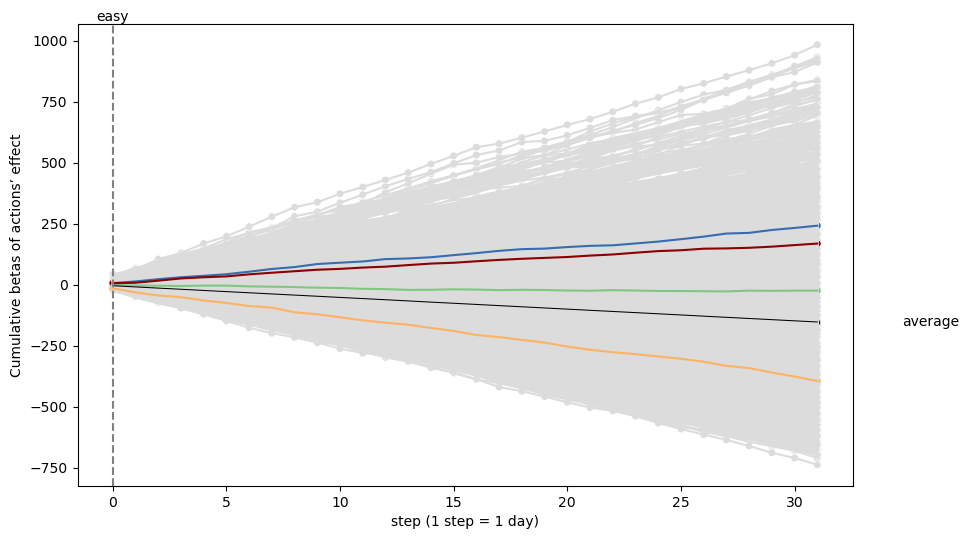

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

# other_points
sns.lineplot(data=other_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, legend=False)
sns.scatterplot(data=other_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, s=30, legend=False)

# few_points
sns.lineplot(data=few_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, ax=ax)
sns.scatterplot(data=few_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, s=30, ax=ax)

# agg_df
sns.lineplot(data=agg_df, x='step_id', y='cumulative_mental_health', color='black', ax=ax, size=2)
sns.scatterplot(data=agg_df, x='step_id', y='cumulative_mental_health', color='black', s=20, ax=ax)

vector = [i * n_days for i in range(1)]

# add lockdown labels and dotted lines
for x_val, label in zip(vector, ['easy']):
    ax.axvline(x=x_val, linestyle='--', color='gray')
    ax.text(x=x_val, y=ax.get_ylim()[1], s=label, va='bottom', ha='center')

avg_mh_text_y = agg_df[agg_df['step_id'] == agg_df['step_id'].max()]['cumulative_mental_health'].values[0]
ax.text(n_days+5, avg_mh_text_y, 'average', va='center', ha='center', color='black')

ax.set_xlabel('step (1 step = 1 day)')
ax.set_ylabel('Cumulative betas of actions’ effect')
ax.get_legend().remove()

plt.show()


### Average mental health for each step coloured by lockdown type

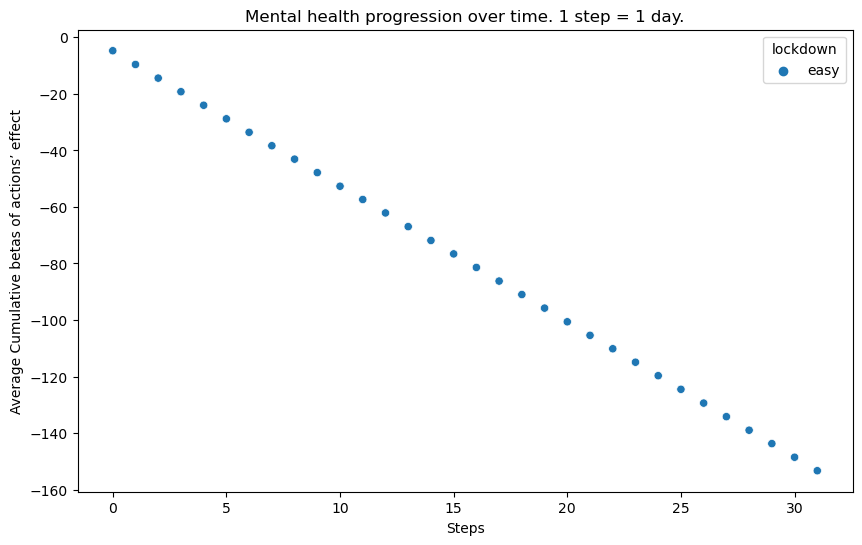

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_data, x='step_id', y='cumulative_mental_health', hue='lockdown')
plt.xlabel('Steps')
plt.ylabel('Average Cumulative betas of actions’ effect')
plt.title('Mental health progression over time. 1 step = 1 day.')
plt.show()

# Step 4. compute probability of developing symptomps of depression

This function is not part of the package, however I provide it here as a suggestion on how to convert he cumulative betas of actions' effect into an estimation of the risk of developing symptoms of depression.

In [21]:
import numpy as np

def convert_beta_to_probability(beta: float, bmax: float) -> float:
    """
    Convert a beta value to the probability of becoming depressed.
    
    This function calculates the probability of becoming depressed based on a given beta value
    and a maximum beta value, using a sigmoid function. The baseline probability
    of depression is set according to the prevalence of depressive disorders in the Netherlands (NL).
    
    Parameters:
    - beta (float): The beta value for which to compute the probability of depression.
    - bmax (float): The maximum beta value (beta_max) corresponding to a high probability of depression.
    
    Returns:
    - float: The computed probability of becoming depressed.
    
    Reference:
    - Prevalence of depressive disorders data is from Our World in Data for the Netherlands (NL). 
    See https://ourworldindata.org/grapher/depressive-disorders-prevalence-ihme?tab=chart&country=NLD
    """
    # Baseline probability of depression in the NL
    p0 = 0.035
    
    # Beta for which we want 0.9 probability of being depressed
    beta_max = bmax
    
    # Compute A - risk scaling factor
    p0_ = np.log((1 - p0) / p0)
    diff_prob = np.log((1 - 0.9) / 0.9)
    A = (p0_ - diff_prob) * beta_max
    
    # compute X0 - risk baseline
    X0 = A * p0_
    
    # Convert beta to probability
    p_beta = 1 / (1 + np.exp((X0 - beta) / A))
    
    return p_beta

In [26]:
betas = data['cumulative_mental_health']
coeff = 0.01 # < numbers equal less variability, > numbers more variability
delta_beta = max(betas) - min(betas)

In [28]:
p = convert_beta_to_probability(betas, bmax = (coeff * delta_beta))

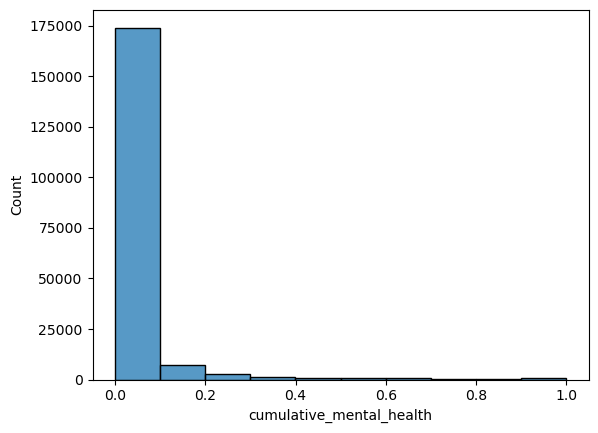

In [35]:
sns.histplot(p, bins=10)
plt.show()